In [22]:
# Allows us to import files from the base folder
import sys
import os
# Get the parent directory of the notebook's folder
base_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.append(base_dir)

# Imports
import jax
import jax.numpy as jnp
from jax import grad, vmap, jit, value_and_grad
import optax

import matplotlib.pyplot as plt

from packages.quantum_error_correction import *
from packages.neural_network import *

from icecream import ic  # For debugging

key = jax.random.key(42)

# Initialize the QEC code that will be used

Rate of non-trivial cases: 31.47%


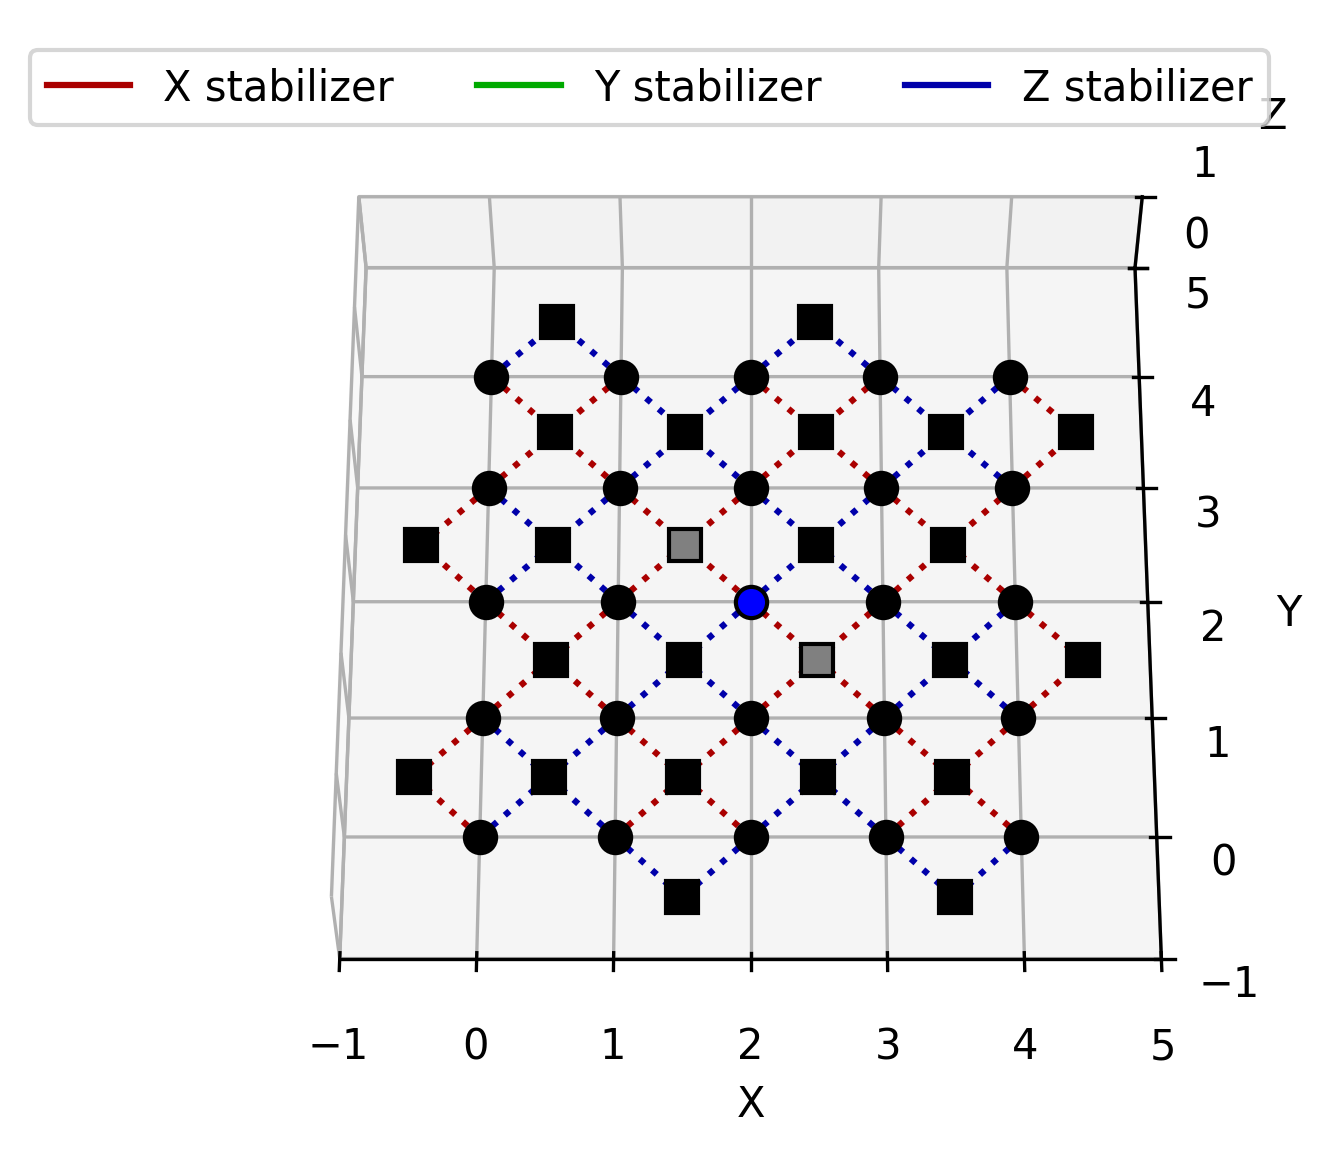

In [23]:
error_prob = [.005, .005, .005]
code_distance = 5

subkey, key = jax.random.split(key)
errors = jax_create_error_batch(*error_prob, size=code_distance**2, batch_size=1, key=subkey)

qec = QEC(surface_code_data(d=code_distance))
Mx, My, Mz = qec.transformation_matrix()
nsq, ndq = Mx.shape
qec.show(errors=errors[0]);

print(f'Rate of non-trivial cases: {1-(1-sum(error_prob))**ndq:.2%}')

# Initialize a neural network (NN)
with random weights and biases

In [24]:
subkey, key = jax.random.split(key)
num_neurons_layers = [nsq, 4*ndq, 2*ndq, 4*ndq]
print(f"Layers: {num_neurons_layers}")
params = NN_init_params( subkey, num_neurons_layers )

# Give the neural network an initial bias towards acting with identity on all data qubits
params['weights'][-1] = params['weights'][-1] * jnp.where(jnp.arange(4*ndq) < ndq, 1.0, 0.1)[:,None]
params['biases'][-1] = jnp.where(jnp.arange(4*ndq) < ndq, 5.0, -5.0)

Layers: [24, 100, 50, 100]


# Functions for evaluating the NN

In [25]:
def NN_raw_to_correction(NN_output: jnp.ndarray) -> jnp.ndarray:
    """
    Normalize the NN output to represent probabilities 
    using the exponentiel of the values as their respective weights
    """
    # logits have values between zero and one
    logits = NN_output.reshape((4, NN_output.shape[0]//4))
    # Normalize so probabilities sum to one
    probabilities = logits / jnp.sum(logits, axis=0)
    return probabilities

NN_raw_to_correction_batch = jax.vmap(
    NN_raw_to_correction, 
    in_axes=0, 
    out_axes=0
)

In [26]:
def NN_correction_to_syndrome(NN_correction: jnp.ndarray, Mx: jnp.ndarray, My: jnp.ndarray, Mz: jnp.ndarray) -> jnp.ndarray:
    """
    Uses the probabilities of the NN_correction to calculate
    the probability that each of the stabilizers will be activated.

    This function does not take into account the correlation between
    stabilizers and merely evaluates each stabilizer independently
    """
    # Note: this is not matrix multiplication but element wise multiplication
    probabilities_x = Mx * NN_correction[1]
    probabilities_y = My * NN_correction[2]
    probabilities_z = Mz * NN_correction[3]
    probabilities = probabilities_x + probabilities_y + probabilities_z
    # Calculate probability that the stabilizer is activated
    p1 = jnp.zeros(probabilities.shape[0])
    for p in probabilities.T:
        #      0 -> 1    1 -> 1
        p1 = (1-p1)*p + p1*(1-p)
    return p1
    

NN_correction_to_syndrome_batch = jax.vmap(
    NN_correction_to_syndrome, 
    in_axes=(0, None, None, None), 
    out_axes=0
)

#### Cost function

In [27]:
def mse_loss_batch(syndromes: jnp.ndarray, params: dict, Mx: jnp.ndarray, My: jnp.ndarray, Mz: jnp.ndarray) -> jnp.ndarray:
    """
    Uses the mean square to evaluate the performance of the NN
    """
    # Calculate the syndome probabilities produced by the correction given by the NN
    NN_raws = NN_batch(syndromes, params)
    NN_corrections = NN_raw_to_correction_batch(NN_raws)
    NN_syndromes = NN_correction_to_syndrome_batch(NN_corrections, Mx, My, Mz)
    # Return the mean square of the NN_syndromes vs the measured syndromes
    return jnp.mean((NN_syndromes - syndromes)**2) + 1E-20 # Add a small number so the loss never reaches zero as that seams to break the optimizer

mse_loss_batch_val_grad = value_and_grad(mse_loss_batch, argnums=1)
mse_loss_batch_val_grad = jax.jit( mse_loss_batch_val_grad  )

# Test it on the randomly initiated NN

In [28]:
# Generate data
batch_size = 1
subkey, key = jax.random.split(key)
errors = jax_create_error_batch(
    px = error_prob[0],
    py = error_prob[1],
    pz = error_prob[2],
    size = ndq,
    batch_size = batch_size,
    key = subkey
)
syndromes = jax_get_syndromes_batch(Mx, My, Mz, errors)

# Run the neural network
NN_raw = NN_batch(syndromes, params)
# NN_raw = jnp.arange(16)[None,:]
ic(NN_raw)
NN_correction = NN_raw_to_correction_batch(NN_raw)
NN_syndrome = NN_correction_to_syndrome_batch(NN_correction, Mx, My, Mz)
loss, gradient = mse_loss_batch_val_grad(syndromes, params, Mx, My, Mz)

# Print the results
print("Pauli correction probability for:\nQubit    I        X        Y        Z\n"+'\n'.join([f'  {i}  '+', '.join([f'{v: 7.1%}' for v in p]) for i, p in enumerate(NN_correction[0].T)]))
print("\nSyndrome probabilities from the NN-predictions:\n"+'\n'.join(f"  {i}  {p:7.1%}" for i, p in enumerate(NN_syndrome[0])))
print(f"\nThe loss of the NN is: {loss:.10f}")


ic| NN_raw: Array([[0.99313533, 0.99320847, 0.99399537, 0.99285513, 0.9942526 ,
                    0.9953034 , 0.99281466, 0.9904206 , 0.9932285 , 0.9952571 ,
                    0.9921416 , 0.9929685 , 0.994987  , 0.994873  , 0.99397624,
                    0.99369484, 0.99490756, 0.9933422 , 0.99404764, 0.99357575,
                    0.9913692 , 0.9940773 , 0.99047285, 0.9949897 , 0.9944759 ,
                    0.0069755 , 0.0067384 , 0.0066342 , 0.0066928 , 0.0067986 ,
                    0.00679083, 0.00663563, 0.0068151 , 0.00671456, 0.00694049,
                    0.00667799, 0.00657716, 0.00671201, 0.00684911, 0.00679081,
                    0.00679047, 0.00695886, 0.00709072, 0.0067575 , 0.00655295,
                    0.00647199, 0.00687262, 0.00657742, 0.00658283, 0.00662447,
                    0.00651507, 0.00682988, 0.00699825, 0.00685234, 0.00679089,
                    0.00661985, 0.00638083, 0.0067524 , 0.0064921 , 0.00646827,
                    0.00644382, 0.006995

Pauli correction probability for:
Qubit    I        X        Y        Z
  0    98.0%,    0.7%,    0.6%,    0.7%
  1    98.0%,    0.7%,    0.7%,    0.6%
  2    98.0%,    0.7%,    0.7%,    0.7%
  3    98.0%,    0.7%,    0.7%,    0.6%
  4    98.0%,    0.7%,    0.7%,    0.6%
  5    98.0%,    0.7%,    0.7%,    0.7%
  6    98.1%,    0.7%,    0.6%,    0.6%
  7    98.0%,    0.7%,    0.7%,    0.7%
  8    98.0%,    0.7%,    0.6%,    0.7%
  9    98.0%,    0.7%,    0.6%,    0.7%
  10    98.0%,    0.7%,    0.6%,    0.7%
  11    98.0%,    0.6%,    0.7%,    0.7%
  12    98.0%,    0.7%,    0.7%,    0.7%
  13    98.0%,    0.7%,    0.6%,    0.7%
  14    98.0%,    0.7%,    0.6%,    0.7%
  15    98.0%,    0.7%,    0.7%,    0.7%
  16    98.0%,    0.7%,    0.6%,    0.7%
  17    98.0%,    0.7%,    0.7%,    0.7%
  18    98.0%,    0.7%,    0.7%,    0.7%
  19    98.0%,    0.6%,    0.7%,    0.7%
  20    98.0%,    0.6%,    0.7%,    0.7%
  21    98.0%,    0.7%,    0.7%,    0.7%
  22    98.0%,    0.7%,    0.7%,    

# Train the NN

In [29]:
learning_rate = 1e-3
optimizer = optax.adam(learning_rate)
opt_state = optimizer.init(params)

# training parameters
num_training_batches = 100_000
batch_size = 256
losses=[]

In [30]:
from IPython.display import clear_output

for idx_batch in range(num_training_batches): 
    # print(f'{idx_batch+1} of {num_training_batches}', end='\r')
    clear_output(wait=True)
    if idx_batch % 100 == 0 and idx_batch >= 100:
        print(f'{idx_batch = }\nMean = {jnp.mean(jnp.array(losses[-100:])):16.14f}\n     ± {jnp.std(jnp.array(losses[-100:])):16.14f}', flush=True)

    # get training batch
    subkey, key = jax.random.split(key)
    errors = jax_create_error_batch(
        px = error_prob[0],
        py = error_prob[1],
        pz = error_prob[2],
        size = ndq,
        batch_size = batch_size,
        key = subkey
    )
    syndromes = jax_get_syndromes_batch(Mx, My, Mz, errors)
    
    # get loss and its gradient with respect to network parameters:
    loss, grads = mse_loss_batch_val_grad(syndromes, params, Mx, My, Mz)

    # Safe-guard against nan values
    # Stopts the training before updating with problematic prams
    if jnp.isnan(loss) or any([jnp.isnan(bias).any() for bias in grads['weights']]):
        print(idx_batch)
        break

    # update the network parameters:
    updates, opt_state = optimizer.update( grads, opt_state )
    params = optax.apply_updates( params, updates )

    # add the loss to the list:
    losses.append(loss)


idx_batch = 99900
Mean = 0.00222960859537
     ± 0.00036690244451


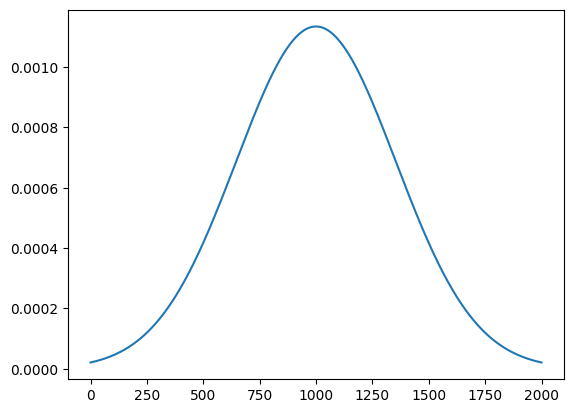

In [32]:
window_size = len(losses) // 50
window_xs = np.linspace(-2, 2, window_size)
window_form = jnp.exp(-window_xs**2)
window = window_form / sum(window_form)

plt.plot(range(window_size), window)

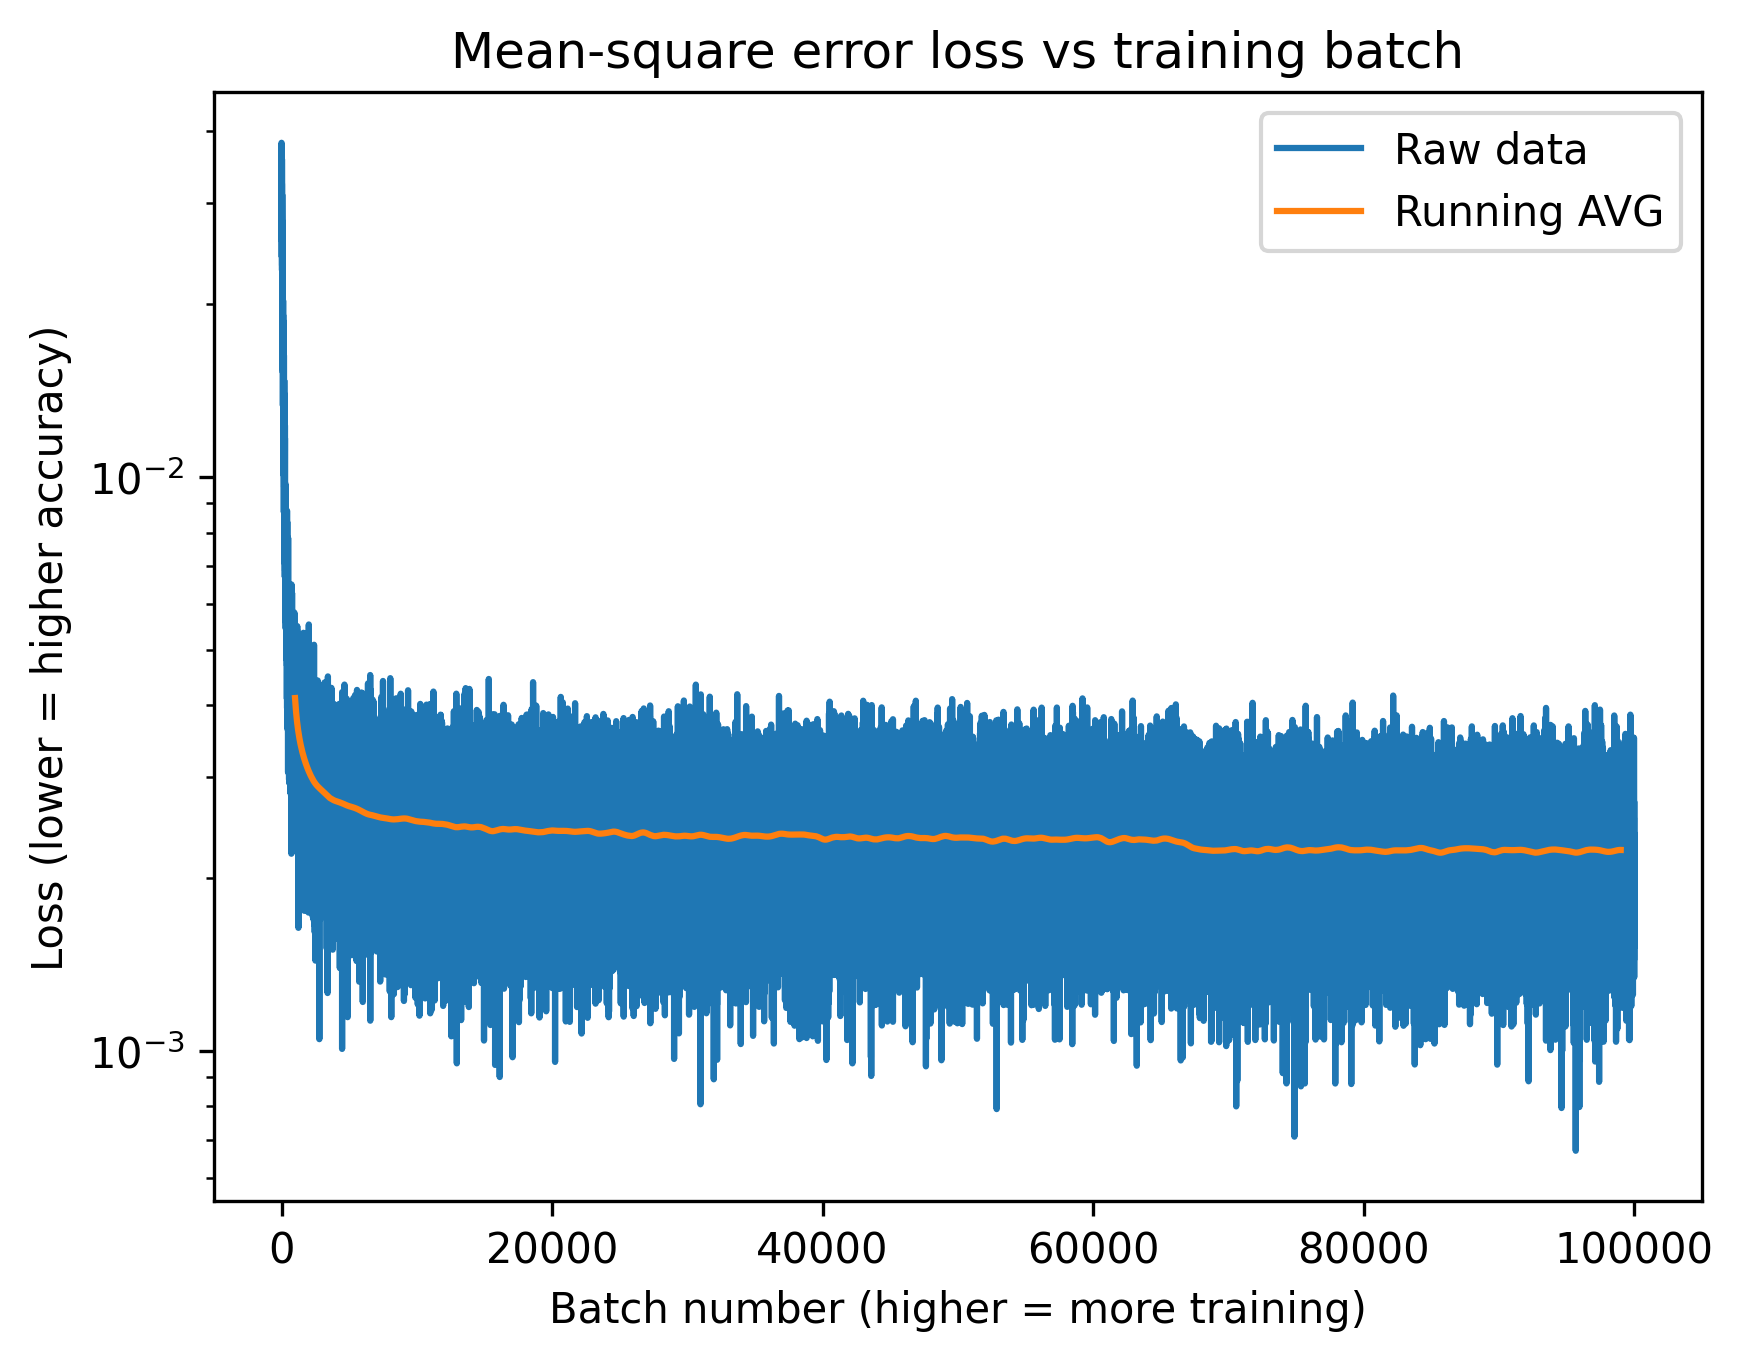

In [39]:
running_avg = jnp.convolve(jnp.array(losses), window, mode='valid')

plt.figure(dpi=300)
plt.plot(jnp.arange(0, len(losses)), losses, label="Raw data")
plt.plot(jnp.arange(0, len(running_avg))+window_size/2, running_avg, label="Running AVG")
plt.legend()
plt.yscale( "log" )
plt.title("Mean-square error loss vs training batch")
plt.xlabel("Batch number (higher = more training)")
plt.ylabel("Loss (lower = higher accuracy)")
plt.show()

In [34]:
# params = load_NN("../trained_NN/NN_SC_D5_V1.json")


The loss of the NN is: 0.0195742249


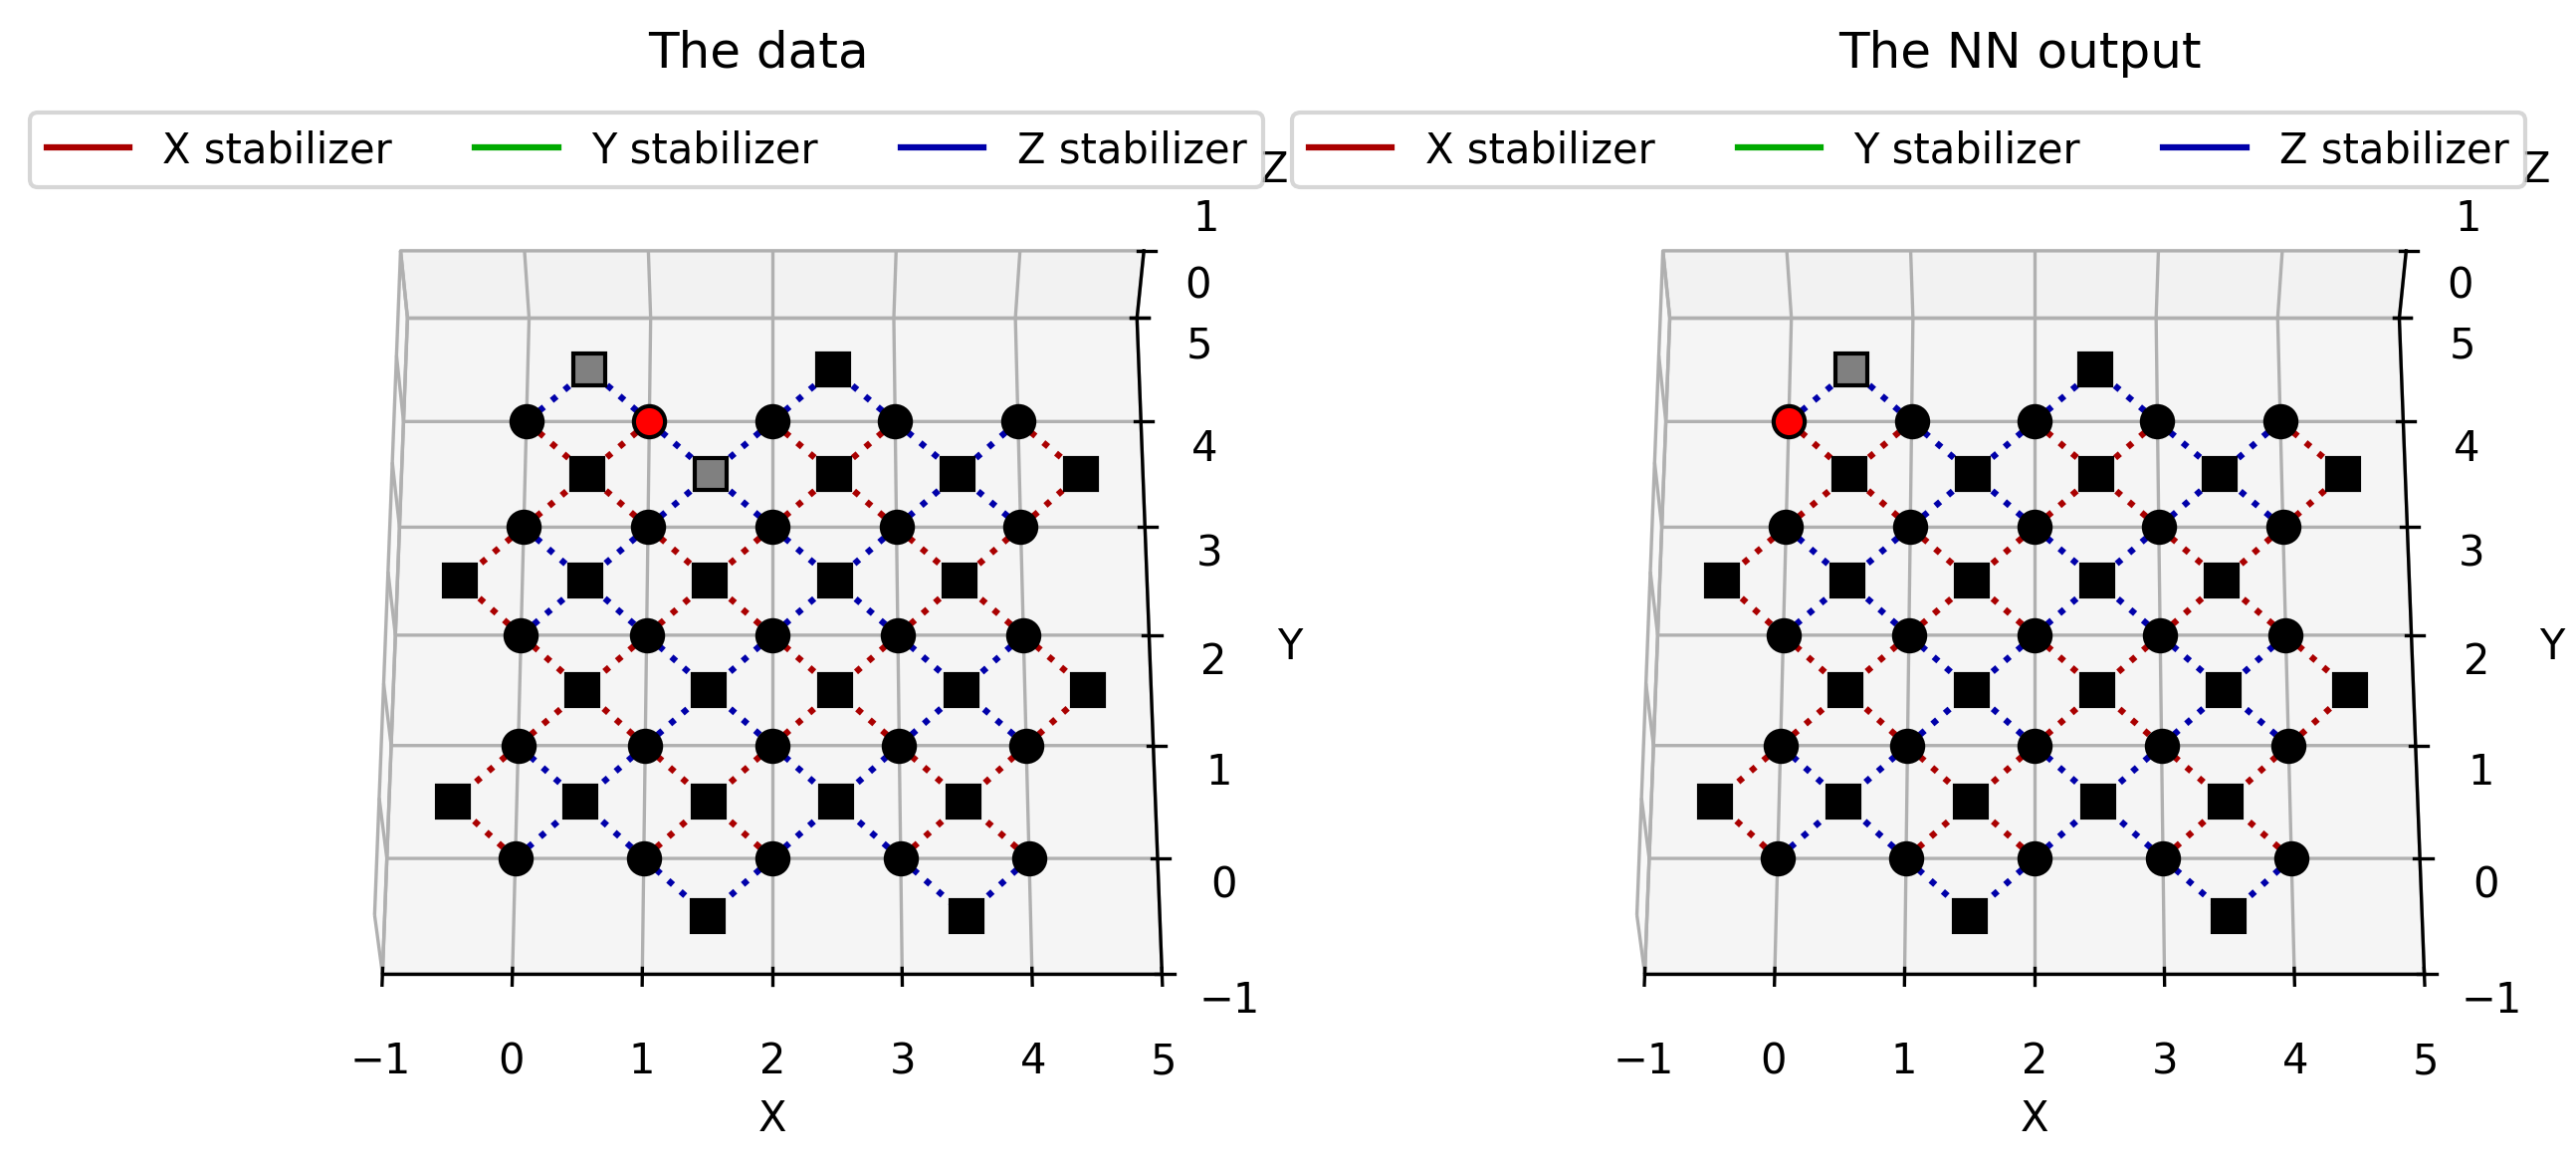

Pauli correction probability for:
Qubit    I        X        Y        Z
  0   100.0%,    0.0%,    0.0%,    0.0%
  1   100.0%,    0.0%,    0.0%,    0.0%
  2   100.0%,    0.0%,    0.0%,    0.0%
  3   100.0%,    0.0%,    0.0%,    0.0%
  4     0.0%,   99.9%,    0.1%,    0.0%
  5    99.9%,    0.0%,    0.0%,    0.1%
  6   100.0%,    0.0%,    0.0%,    0.0%
  7   100.0%,    0.0%,    0.0%,    0.0%
  8    84.3%,   15.7%,    0.0%,    0.0%
  9    82.4%,   17.6%,    0.0%,    0.0%
  10   100.0%,    0.0%,    0.0%,    0.0%
  11   100.0%,    0.0%,    0.0%,    0.0%
  12    99.9%,    0.0%,    0.0%,    0.1%
  13    82.7%,   17.2%,    0.0%,    0.0%
  14    84.0%,   16.0%,    0.0%,    0.0%
  15    99.9%,    0.1%,    0.0%,    0.0%
  16    99.9%,    0.1%,    0.0%,    0.0%
  17   100.0%,    0.0%,    0.0%,    0.0%
  18   100.0%,    0.0%,    0.0%,    0.0%
  19   100.0%,    0.0%,    0.0%,    0.0%
  20   100.0%,    0.0%,    0.0%,    0.0%
  21   100.0%,    0.0%,    0.0%,    0.0%
  22   100.0%,    0.0%,    0.0%,    

In [35]:
# Generate data
batch_size = 1
subkey, key = jax.random.split(key)
errors = jax_create_error_batch(
    px = error_prob[0],
    py = error_prob[1],
    pz = error_prob[2],
    size = ndq,
    batch_size = batch_size,
    key = subkey
)
syndromes = jax_get_syndromes_batch(Mx, My, Mz, errors)

# Run the neural network
NN_raw = NN_batch(syndromes, params)
NN_correction = NN_raw_to_correction_batch(NN_raw)
NN_syndrome = NN_correction_to_syndrome_batch(NN_correction, Mx, My, Mz)
loss, gradient = mse_loss_batch_val_grad(syndromes, params, Mx, My, Mz)
print(f"\nThe loss of the NN is: {loss:.10f}")

# Show the results
fig, (ax1, ax2) = plt.subplots(ncols=2, subplot_kw={'projection': '3d'}, dpi=300)
fig.set_figwidth(10)
fig.set_figheight(10)
qec.show(axis=ax1, errors=errors[0], title="The data")
qec.show(axis=ax2, errors=NN_correction[0].argmax(axis=0), title="The NN output")
plt.show()

# Print the results
print("Pauli correction probability for:\nQubit    I        X        Y        Z\n"+'\n'.join([f'  {i}  '+', '.join([f'{v: 7.1%}' for v in p]) for i, p in enumerate(NN_correction[0].T)]))
print("\nSyndrome probabilities from the NN-predictions:\n"+'\n'.join(f"  {i}  {p:7.1%}" for i, p in enumerate(NN_syndrome[0])))

In [ ]:
# save_NN("../trained_NN/NN_SC_D5_V2.json", params)